# Web-scraping tutorial

As far as I know, this hasn't been the specific topic of any particular published study, but any casual consumer can observe that womens clothing tends to have a wider variety of options, including colors. Is Patagonia providing guys with a variety of color options?

Collecting data from websites is a great way to build a dataset to analyze and practice your data science skills - in fact, web scraping itself is a data science skill! Many data scientists need to scrape data from the web at some point in their careers, and many data scientists use this skill on the daily! So, it's definitely something worth learning. 

Until recently, I didn't know that the developer view of a website contained a treasure trove of data, I just thought it was a scary sidebar that popped up when I accidentally pressed the wrong combination of keys on a mac keyboard. 

However, after learning some basic web scraping techniques, the developer view has gone from intimidating to interesting, and hopefully after reading this post you'll agree. 

In this tutorial we'll work through a simple web scraping exercise to gather data on items sold on Patagonia (the clothing brand)'s website and finish up with a neat little hypothesis test.

This is by no means a comprehensive tutorial, but it should be enough to get you started. Further resources for learning web scraping in Python are listed at the bottom of the page.

## Goal: Scrape the item price and color options for each clothing item at Patagonia to compare the average cost and color availability for men's and women's clothing. 

Why this goal? [Several studies](https://www.insider.com/women-more-expensive-products-2018-8#girls-backpacks-cost-slightly-more-than-boys-11) have found that products for women tend to be pricier than products for men, and this [includes clothing](https://www1.nyc.gov/assets/dca/downloads/pdf/partners/Study-of-Gender-Pricing-in-NYC.pdf)! We want to see if Patagonia falls into this same gender disparity, or if they are doing a good job at pricing their clothes equally, regardless of the "gender" 

(I'm using "quotes" above because these gendered categorizations for clothing assume the traditional binary gender identities, which aren't necessarily valid -- you can buy clothing from whichever category you want!)  

## Getting Started - Libraries

There are several libraries available for web scraping in Python, but in this tutorial we'll be using `BeautifulSoup` and the `urllib`.

Other libraries you can use include: `requests`, `Selenium`, and `Scrapy`

If you are using Anaconda with Python (as I am now, writing this in a Jupyter Notebook) you can install the the `BeautifulSoup` module in the command line by typing:

`conda install BeautifulSoup4` 

If you use a `pip` install instead you can install the `BeautifulSoup` module by typing: 

`pip install BeautifulSoup4` 

The `urllib` module is pre-loaded in Python so you do not need to install it using the command line

Other libraries we will use include: 

* MatPlotLib (for plotting)

* Seaborn (for plotting)

* Pandas (for working with dataframes)

Which you can install using the same method as we used for the `BeautifulSoup` library

Once your libraries are installed in your virtual environment, you can import them into your script

In [1]:
from bs4 import BeautifulSoup ## bs4 is a submodule within BeautifulSoup that has the functions we need
import urllib.request ## we want the request function from the urllib library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt ## pyplot is a submodule within matplotlib
%matplotlib inline 
## this allows us to print the plots in the Jupyter Notebook

## Getting Started - "Inspect" the Website

For this exercise we'll be using [Patagonia website](https://www.patagonia.com/home/)

This is where we start to look at the "developer" view of a public website. The "inspect" view for a webpage's html can be viewed either by right clicking anywhere on the page and selecting insepct, or going to the "view" tab in the top browser bar and selecting view > developer> insepct elements. The inspect view will pop up as a side bar on the right of the page. 

<img src="RTRunway_Patagonia_InspectView.png">


### Understanding the webpage html and inspect view

Okay, there's a lot to unpack here, and the best thing to do is just play around with this on whatever website you are interested in, but here's a brief overview of what we're looking at: 

html code contains "tags"
These tags are denoted by `<...>` in the html code

<img src="RTRunway_Patagonia_TagExample.png">

 
Tags contain the information that is responsible for the webpage that we can see!
A tag is opened with `<...>` and closed with `</...>`

<img src="RTRunway_Patagonia_OpenCloseTagExample.png">

You can see as you hover over any tag on in the html code (in the inspect side window) it will highlight the portion of the webpage that the selected tag is responsible for

Tags are organized into a tree - the subtags within a tag are "children", any tag that has a "child" is a "parent", and two tags on an equal plane of the html are "siblings"

To visually inspect a tag's children, you can click the drop down arrow to the left of a tag

You can continue to view each tag's children by clicking the drop arrows, and by hovering over each line in the inspect window, you can see the smaller and smaller portion of the website that each tag is responsible for

<img src="RTRunway_Patagonia_TagChildrenExample.png">

### So what information do we want? 

Our goal, as stated above, is compare the price and number of color options between the men's and women's clothing. Differences in clothing price might also vary by item category, so we'll want those data as well. 

Therefore, for each clothing item on the website, we want

* item name

* item price

* item "gender"

* number of color options for the item

* item category (e.g. jacket, shoes, pants, etc.)

Before we can get any of that data, we need to send the html information into Python, which we'll do next!

## Get the webpage html

Finally, now we get to write some code!

The basic process for getting the html for a webpage into Python so you can begin extracting data is: 

1) Load the URL

2) Read (or "open") the URL in Python

3) Parse the URL's html into a BeautifulSoup object

Now, our ultimate goal of getting gender/category/price/colors for every clothing item is actually quite complex, so let's start simple and build up.  

First, we'll only focus on getting the price and color information from every clothing item in one category from the women's section. We'll start with women's jackets, just because. 

The URL for women's jackets and vests is: https://www.patagonia.com/shop/womens-jackets-vests

In [2]:
## load the URL
url = 'https://www.patagonia.com/shop/womens-jackets-vests'

In [3]:
## read or "open" the URL
page = urllib.request.urlopen(url)

In [4]:
## parse the URL's html into a BeautifulSoup object
soup = BeautifulSoup(page, 'html.parser')

In [5]:
## see that we've created a BeautifulSoup object
type(soup)

bs4.BeautifulSoup

## Scrape the data from the html!

### Getting info on each product

You can print that soup object if you want to look at it. If basically looks like a big jumble of html, you've done it right! 

Now, we can see from inspecting the page that each product is stored under a `div` parent tag with the attributes `class="container search-results"`

`BeautifulSoup` has two very useful functions, `.find` and `.find_all` for extracting information from a html

`.find` finds the first tag of a designated type (e.g. `div`) and returns a `tag` object

`.find_all` will find all the tags of a designated type within an html and returns a list of the results

We can use the `.find` function from `BeautifulSoup` to find the specific parent tag that contains ALL the products underneath it (and each product's information is stored in the children tags of the parent tag we are searching for).

In [6]:
## get the parent tag that contains all the products
products = soup.find('div', attrs = {'class':'container search-results'})

We can use `find_all` to search within the parent tag for each of the individual products, which are also stored under `div` tags with the attributes `class="product"` Within these `div` tags there is the information about the product price and the number of color options available for said product. 

In [7]:
## find all the individual product tags that contain the product data we want to scrape
products = products.find_all('div', attrs = {'class':'product'}) 

In [8]:
## overall there are 64 products on this page
len(products)

64

Cool, now we have a list of information for each of the 64 products listed at on the main page of women's jackets and vests. If you want to see what each tag looks like you can print one element of the `products` list and see what it contains. 

64 products - neat! But you'll notice that if you scroll down to the bottom of the Patagonia page there is a 'load more' button that, you guessed it, loads more products. 

<img src="RTRunway_Patagonia_LoadMoreButton.png">


We want those products too! If you click load more on the website, the rest of the products will indeed load. However, the URL itself doesn't change. Therefore, getting the remaining products' information won't be as simple as reading in another URL and performing the same process as above. 

Hmmm, so what do we do? We can, within our code, initiate a "click" of the "load more" button and extract the remaining products that way. 

First we must find where to "click." The "load more" button is stored in the html under the `button` tag with the attributes `class="btn btn-lg btn-dark"` (we figured this out through the inspection panel on the webpage, and because it makes sense that a webpage button would be tagged as, well, a button). 

In [9]:
## get the button to "click"
buttons = soup.find_all('button', attrs = {'class': 'btn btn-lg btn-dark'})

In [10]:
len(buttons) ## two buttons fit this description

2

In [11]:
buttons[1] ## we want the second one that will initiate "load more"

<button class="btn btn-lg btn-dark" data-url="https://www.patagonia.com/on/demandware.store/Sites-patagonia-us-Site/en_US/Search-UpdateGrid?cgid=womens-jackets-vests&amp;start=64&amp;sz=40">
Load More
</button>

We've located our "load more" button and we can get the url (that you can see above is stored in the 'data-url' attribute) that the button leads to

In [12]:
buttons[1].get('data-url')

'https://www.patagonia.com/on/demandware.store/Sites-patagonia-us-Site/en_US/Search-UpdateGrid?cgid=womens-jackets-vests&start=64&sz=40'

Using the URL, we can initiate a "click" within Python to extract the products that this "load more" URL leads to

In [13]:
url_2 = buttons[1].get('data-url')
page_2 = urllib.request.urlopen(url_2)
soup_2 = BeautifulSoup(page_2, 'html.parser')
products_2 = soup_2.find_all('div', attrs = {'class':'product'})

In [14]:
len(products_2) ## information for 24 more products

24

In [15]:
## combine our first and second products lists into one using the simple `+` operator
products = products + products_2

In [16]:
len(products) ## we have 88 products in women's jackets and vest's category

88

### Item names

Overall, we have 88 products from the women's jackets and vests category that we can scrape the product information from (price and number of color options)

We'll want to arrange this information into a Pandas dataframe, and in order to keep track all of this info we'll want a dataframe with the columns: item name, item gender, item category, item price, number of item colors 

Knowing that, we can initaite our data frame with the item name information (our first "scrape"!) 

The names are contained in the `h4` tag with the attributes `class="product-tile__name"

In [17]:
## scrape the item names
item_names = [] ## empty list to add names to
for product in products:
    item_names.append(product.find('h4', attrs = {'class':'product-tile__name'}).string)

In [18]:
item_names[0:5] ## look at a slice of the item names

["W's Better Sweater® 1/4-Zip",
 "W's Los Gatos 1/4-Zip",
 "W's Re-Tool Snap-T® Pullover",
 "W's Better Sweater® Jacket",
 "W's Nano Puff® Jacket"]

In [19]:
## and put that into a dataframe
df = pd.DataFrame(item_names, columns = ['item_name'])

In [20]:
df ## looks good!

,item_name
0,W's Better Sweater® 1/4-Zip
1,W's Los Gatos 1/4-Zip
2,W's Re-Tool Snap-T® Pullover
3,W's Better Sweater® Jacket
4,W's Nano Puff® Jacket
...,...
83,W's Jackson Glacier Jacket
84,W's Stand Up™ Jacket
85,W's Ascensionist Jacket
86,W's Tough Puff Hoody


### Item prices

After we have made our dataframe with item names, we can add the price that corresponds to each item

The price information is contained in the `span` tag with the attributes `class="value"` and we very specifically want the string information (i.e. the actual price) within the tag, so we further add the function `get('content')` to get the content of the tag

In [21]:
prices = []
for product in products:
    prices.append(product.find('span', attrs = {'class':'value'}).get('content'))
    
## add to the dataframe
df['item_price'] = prices

In [22]:
df ## cool!

,item_name,item_price
0,W's Better Sweater® 1/4-Zip,99
1,W's Los Gatos 1/4-Zip,99
2,W's Re-Tool Snap-T® Pullover,119
3,W's Better Sweater® Jacket,139
4,W's Nano Puff® Jacket,199
...,...,...
83,W's Jackson Glacier Jacket,349
84,W's Stand Up™ Jacket,129
85,W's Ascensionist Jacket,499
86,W's Tough Puff Hoody,249


Because we extracted the price information from the tag as a string, but we actually want these data to be stored as numerical values, let's check what kind of data the item prices are stored as and if we need to transform them to numerical

In [23]:
df['item_price'].dtype ## not numeric

dtype('O')

In [24]:
df['item_price'] = pd.to_numeric(df['item_price'])

In [25]:
df['item_price'].dtype ## now it's numeric

dtype('int64')

### Item colors

Alright, with that taken care of, let's see if we can't find a way to count the number of color options available for each item. 

From inspecting the html code, we can see that this specific information isn't actually contained in the code anywhere. So, we'll have to Macguyver something. 

What we can see in the code that each product has color swatches, and these swatches each have their own `<li>` tag, therefore, we can count the number of colors available per item by counting the number of `<li>` tags within each item in `products`

To count these `<li>` tags we can define a very simple function, which we will call `countProductColors`

In [26]:
##define a counting function
def countProductColors(product):
    """Returns the number of color options available for an item on the Patagonia website"""
    temp = product.find_all('li')
    num_col = len(temp)
    return num_col


Then we can loop this color swatch counting function over each item within `products`

In [27]:
item_colors = []
for product in products:
    item_colors.append(countProductColors(product))
    
## add to the dataframe
df['item_colors'] = item_colors

In [28]:
df ## cool! It all worked! That's awesome. 

,item_name,item_price,item_colors
0,W's Better Sweater® 1/4-Zip,99,9
1,W's Los Gatos 1/4-Zip,99,6
2,W's Re-Tool Snap-T® Pullover,119,8
3,W's Better Sweater® Jacket,139,10
4,W's Nano Puff® Jacket,199,8
...,...,...,...
83,W's Jackson Glacier Jacket,349,2
84,W's Stand Up™ Jacket,129,2
85,W's Ascensionist Jacket,499,3
86,W's Tough Puff Hoody,249,2


The last couple of pieces of information that we are missing from our dataframe is the info on gender and product category associated with each item. 

To add these, we can simply insert columns with repeated values into our existing dataframe

In [29]:
df.insert(0, 'item_gender', 'womens') ## insert the "gender" as the first column

In [30]:
df.insert(1, 'item_category', 'jackets') ## insert the category as the second column

In [31]:
df ## and that's all of our data scraped!

,item_gender,item_category,item_name,item_price,item_colors
0,womens,jackets,W's Better Sweater® 1/4-Zip,99,9
1,womens,jackets,W's Los Gatos 1/4-Zip,99,6
2,womens,jackets,W's Re-Tool Snap-T® Pullover,119,8
3,womens,jackets,W's Better Sweater® Jacket,139,10
4,womens,jackets,W's Nano Puff® Jacket,199,8
...,...,...,...,...,...
83,womens,jackets,W's Jackson Glacier Jacket,349,2
84,womens,jackets,W's Stand Up™ Jacket,129,2
85,womens,jackets,W's Ascensionist Jacket,499,3
86,womens,jackets,W's Tough Puff Hoody,249,2


## Putting it all together!

Excellent! We have successfully scraped all of the product information that we wanted from this one section of the website and turned it into structured data. 

But, we're not done! Now that we've done this once, we want to be able to do it for ALL of the clothing (both mens and womens) in every clothing category! A new challenge, but now that we are well versed in tags and basic data scraping, I think we will be able to figure out a (somewhat elegant) way to do this. 

What we need to consider is: 

a) getting clothing information from both the womens and mens sections

b) associating each clothing item with the category that it is listed under

On the homepage of the Patagonia website, we can see that there are links to all of the womens and mens clothing categories. When we click on one of these categories, we can see that the URL simply adds a suffix to the main Patagonia URL (e.g. '/shop/womens/fleece'), so we can navigate within python to each clothing category via the links contained in the Patagonia homepage. On top of that, the URL itself contains information on the clothing category that we have navigated to (e.g. 'fleece'), information that we can save to our dataframe to automatically categorize each clothing item that we scrape. 

So, to get each clothing category's link, we can search within the html of the Patagonia homepage. Before we can do that, we need to go through our steps of designating the url, "reading" the url, and parsing the html for the Patagonia homepage. 

In [32]:
url = 'https://www.patagonia.com/home/'
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'html.parser')

If we inspect the html, either in Python or using the inspect window in our browser, we'll notice that each clothing category link is contained within an `<a>` tag with the attributes `class="demi"` (`<a>` tags are used to designate hyperlinks within html, so if you're looking for a link, look for an `<a>` tag!). Let's search our 'soup' for all the `<a>` tags

In [33]:
results = soup.find_all('a', attrs = {'class':'demi'})

In our results, we want all of the links that will lead us to the womens and mens clothing sections, we don't care about the ones that will take us to camping gear or kids products. However, the womens and mens sections have very similar categories, and we want to distinguish each product as being categorized as womens or mens, so to maintain that information we can pull out all the links within our `results` that contain the phrase "womens" or "mens" and these will a) only give us links for the womens and mens sections, and b) maintain the information about whether or not a catgory is associated with womens or mens products

Within each `<a>` tag in our results, there is the class `href` which contains the link itself, so we can use the function `get('href')` to extract this info and search for the "womens" and "mens" strings within the link 

In [34]:
def get_refs(gender, results):
    """returns the href strings for each clothing category in the mens or womens categories"""
    hrefs = []
    for result in results:
        if '/'+gender in result.get('href'):
            hrefs.append(result.get('href'))
    return hrefs

In [35]:
w_hrefs = get_refs('womens', results)

In [36]:
m_hrefs = get_refs('mens', results)

In [37]:
w_hrefs

['/shop/womens-new-arrivals',
 '/shop/womens-jackets-vests',
 '/shop/womens-fleece',
 '/shop/womens-sweatshirts-hoodies',
 '/shop/womens-sweaters',
 '/shop/womens-shirts',
 '/shop/womens-t-shirts',
 '/shop/womens-pants',
 '/shop/womens-shorts',
 '/shop/womens-dresses-skirts',
 '/shop/womens-jumpsuits-overalls',
 '/shop/womens-swimwear',
 '/shop/womens-wetsuits',
 '/shop/womens-waders',
 '/shop/womens-baselayers',
 '/shop/womens-bras-underwear',
 '/shop/womens-socks',
 '/shop/womens-accessories',
 '/shop/womens-workwear-clothing',
 '/shop/womens-worn-wear']

In [38]:
m_hrefs

['/shop/mens-new-arrivals',
 '/shop/mens-jackets-vests',
 '/shop/mens-fleece',
 '/shop/mens-sweatshirts-hoodies',
 '/shop/mens-sweaters',
 '/shop/mens-shirts',
 '/shop/mens-t-shirts',
 '/shop/mens-pants',
 '/shop/mens-shorts',
 '/shop/mens-board-swim-shorts',
 '/shop/mens-wetsuits',
 '/shop/mens-waders',
 '/shop/mens-baselayers',
 '/shop/mens-underwear',
 '/shop/mens-socks',
 '/shop/mens-accessories',
 '/shop/mens-workwear-clothing',
 '/shop/mens-worn-wear']

There's a couple of categories in both the womens and mens clothing that we are not explicitly interseted in - those are the "new arrivals" and "worn gear"

In [39]:
w_hrefs = w_hrefs[1:19]
m_hrefs = m_hrefs[1:17]

### Creating a function

We now have all of our URL "suffixes" which we can affix to the main Patagonia URL to link to each clothing category. Then we can do what we did above but for each of the hrefs in our list of mens and womens hrefs. Also, since we are doing both the womens and mens sections and we have two separate lists of hrefs, we'll have to do this twice. Better than copying and pasting all the code twice, we can write a function that will take the 'gender' as an argument and the list of 'href's as an argument and that way we can do this in a streamlined way for both men and women. 

To define the function, we can just wrap up everything that we did above inside of a function and replace anywhere that we specified "mens" or "womens" with a generic "gender" argument, and anywhere that we would specify w_hrefs or m_hrefs with a generic "hrefs" argument.

We'll call this function `patagoniaScrape` -- note the comments regarding adding the item category information

In [40]:
def patagoniaScrape(gender, hrefs): ## gender argument is a string, hrefs is a list of href URL suffixes
    
    """returns product item name, category, price, and number of color options from the Patagonia website"""

    ## load the main url and add the href suffix - then perform all the functions below for each href in the list
    item_data = []
    for href in hrefs:
        url = 'https://www.patagonia.com'
        w_url = url+href
        page = urllib.request.urlopen(w_url)
        soup = BeautifulSoup(page, 'html.parser')
    
## find the products on the main page -- they are under class ="container search results"
        products = soup.find('div', attrs = {'class':'container search-results'})

## then each product is under the class product within the search results class tag
        products = products.find_all('div', attrs = {'class':'product'}) 
    
## find the "load more" products
        buttons = soup.find_all('button', attrs = {'class': 'btn btn-lg btn-dark'})
    
## some pages don't have 'load more' buttons because all products appear on first page, so we build an if statement
## to initiate the "load more" click if that section does indeed have the specified load more button
        if len(buttons) > 0:
            url_2 = buttons[0].get('data-url')
            page_2 = urllib.request.urlopen(url_2)
            soup_2 = BeautifulSoup(page_2, 'html.parser')
            products_2 = soup_2.find_all('div', attrs = {'class':'product'})
    
    ## add the "load more" products to the main page products
            products = products + products_2
    
## scrape the item names for each product in the category
        item_names = []
        for product in products:
            item_names.append(product.find('h4', attrs = {'class':'product-tile__name'}).string)
    
## define a pandas dataframe using the item names
        df = pd.DataFrame(item_names, columns = ['item_name'])
    
## scrape the item price
        prices = []
        for product in products:
            prices.append(product.find('span', attrs = {'class':'value'}).get('content'))
    
## add to the dataframe
        df['item_price'] = pd.to_numeric(prices) ## make sure the prices are numeric not strings
    
## scrape the number of colors per item
## first need to define a counting function
        def countProductColors(product):
            temp = product.find_all('li')
            num_col = len(temp)
            return num_col

## now can scrape the number of colors per item using the counting function
        item_colors = []
        for product in products:
            item_colors.append(countProductColors(product))
    
## add to the dataframe
        df['item_colors'] = item_colors

## this is new (we didn't do it in the "women's jackets" example above)
## because we are cycling through each href to get the product information and adding it all
## to the same dataframe, we'll want the item category information to be added to the dataframe as well so we can
## distinguish among categories. To do this, we take the string information contained within the 'href'
## (e.g. womens-fleece) and split it at the '-' (e.g. []'womens', 'fleece']) and retain the second element 
## (e.g. 'fleece') and add that as the item category information

## get the item category
## split the href to get the category then second split removes the 'womens' or 'mens' info
        item_category = href.split('/')[2].split('-')[1]

## insert the item gender information to the dataframe
        df.insert(0, 'item_gender', gender)

        df.insert(1, 'item_category', item_category)
    
        item_data.append(df)
    
    item_data = pd.concat(item_data)
    return(item_data)

In [41]:
w_data = patagoniaScrape('womens', w_hrefs)

In [42]:
w_data ## looks good!

,item_gender,item_category,item_name,item_price,item_colors
0,womens,jackets,W's Better Sweater® 1/4-Zip,99.0,9
1,womens,jackets,W's Los Gatos 1/4-Zip,99.0,6
2,womens,jackets,W's Re-Tool Snap-T® Pullover,119.0,8
3,womens,jackets,W's Better Sweater® Jacket,139.0,10
4,womens,jackets,W's Nano Puff® Jacket,199.0,8
...,...,...,...,...,...
13,womens,workwear,Fisherman's Rolled Beanie,35.0,3
14,womens,workwear,Tin Shed Hat,39.0,4
15,womens,workwear,Hose-Down Slicker Bib Overalls,119.0,2
16,womens,workwear,Hose-Down Slicker Jacket,179.0,2


In [43]:
m_data = patagoniaScrape('mens', m_hrefs)

In [44]:
m_data ## looks good too!

,item_gender,item_category,item_name,item_price,item_colors
0,mens,jackets,M's Better Sweater® 1/4 Zip,99.0,12
1,mens,jackets,M's Torrentshell 3L Jacket,149.0,10
2,mens,jackets,M's Down Sweater,229.0,7
3,mens,jackets,M's Nano Puff® Vest,149.0,6
4,mens,jackets,M's Better Sweater® Jacket,139.0,13
...,...,...,...,...,...
31,mens,workwear,M's Long-Sleeved Shop Shirt,85.0,2
32,mens,workwear,M's Fog Cutter Sweater,99.0,3
33,mens,workwear,M's Iron Forge Hemp® Canvas Insulated Overalls,199.0,1
34,mens,workwear,M's Long-Sleeved Western Snap Shirt,79.0,4


## Data Cleaning

One important note is that the product categorizations on the Patagonia website are not mutually exclusive (e.g. a fleece could be categorized as both a "jacket" and a "sweater"), therefore by scraping each product based on its category, we now have duplicated items in the dataset. We'll keep only one entry of the duplicated items.

In addition, some products are unisex and are listed in both categories (e.g. baseball hats for example) so we will remove those. 

Both of those things will be easy enough, but first we must check for any other weirdness or errors in our other columns like missing values, strangely high values or incorrect datatypes (i.e. a string where there should be a numeric)

In [45]:
m_data.shape

(597, 5)

In [46]:
w_data.shape

(557, 5)

In [47]:
item_data = pd.concat([w_data, m_data], axis = 0) ## concatenate the two datasets so we can check them both at once 
## (their separation will come in handy later on)

In [48]:
sum(item_data['item_category'].isnull())

0

In [49]:
sum(item_data['item_name'].isnull())

0

In [50]:
sum(item_data['item_price'].isnull())

0

In [51]:
sum(item_data['item_price'].isnull())

0

Check for data types

In [52]:
item_data.dtypes.astype(str).to_dict()

{'item_gender': 'object',
 'item_category': 'object',
 'item_name': 'object',
 'item_price': 'float64',
 'item_colors': 'int64'}

And if we have any weird values like values that are abnormally high or low or negative, the easiest way to check that is through data visualizations that we will do later on. 

Cool so that all looks good, let's now remove the items that are listed in both the mens and womens sections (i.e. the "unisex" items)

To do that, we'll create a "clipping mask" for our mens and womens dataframes where we remove the items that are present in both the mens and womens datasets. 
To create the mask we will using the function`isin` to identify which of the item names in womens items are also in the mens items. This function returns a Boolean string with "True" values if the values are in both. To select the values from the dataframe that ARENT in both mens and womens then, we will have to invert that Boolean string, so that the unique items are "True" in the mask and the the items in both the mens and womens categories are "False". To reverse the Boolean string we will use the `numpy` function `logical_not`

In [53]:
import numpy as np

In [54]:
## item names that are in both the mens and womens categories
inboth = w_data['item_name'].loc[w_data['item_name'].isin(m_data['item_name'])]

In [55]:
## .logical_not inverts the boolean to turn the "is in" to "is not in" essentially
mask = np.logical_not(w_data['item_name'].isin(inboth))

In [56]:
w_data = w_data[mask]

In [57]:
mask = np.logical_not(m_data['item_name'].isin(inboth))

In [58]:
m_data = m_data[mask]

In [59]:
item_data = pd.concat([w_data, m_data], axis = 0)

Now we can move on to removing the duplicated item entries WITHIN the categories (e.g. a fleece listed as both a jacket and a sweater)

We'll find the duplicated items using the `duplicated` function which will return a Boolean. We will then flip the Boolean again using `logical_not`. 

We are specifying in the `duplicated` function that we want to keep the first entry of any duplicated item. We could devise other ways to come up with which item to keep (like randomly pick which of the duplicated item entries to keep) or pick the last entry instead of the first, but for our purposes it doesn't much matter, so we can just pick the first.

In [60]:
## how many unique products are there in the dataset?
len(set(item_data['item_name']))
## 699

699

In [61]:
item_data.shape ## but there are 946 rows, so we we do have duplicated products indeed

(946, 5)

In [62]:
mask = item_data['item_name'].duplicated(keep = 'first')

In [63]:
# mask = [not i for i in mask] another way to invert a boolean

In [64]:
## because the above actually saves the values that we WANT as "False" 
## we want those to be "True" so we can index by them
## so let's flip them
mask = np.logical_not(mask)

In [65]:
item_data = item_data[mask]

In [66]:
## and check that it worked
item_data.shape 
## yup now we only have as many rows as there are unique values

(699, 5)

### The final dataset!

In [67]:
item_data ## and that's our dataset!

,item_gender,item_category,item_name,item_price,item_colors
0,womens,jackets,W's Better Sweater® 1/4-Zip,99.0,9
1,womens,jackets,W's Los Gatos 1/4-Zip,99.0,6
2,womens,jackets,W's Re-Tool Snap-T® Pullover,119.0,8
3,womens,jackets,W's Better Sweater® Jacket,139.0,10
4,womens,jackets,W's Nano Puff® Jacket,199.0,8
...,...,...,...,...,...
2,mens,underwear,"M's Essential Boxer Briefs - 6""",32.0,8
3,mens,underwear,"M's Essential Boxer Briefs - 3""",32.0,8
4,mens,underwear,M's Essential Boxers,32.0,8
5,mens,underwear,"M's Essential A/C® Boxer Briefs - 6""",34.0,3


Now that we have our dataset, we can look for differences in prices between womens and mens clothing categories

## Visualizing the data

We can use the `seaborn` and `matplotlib` modules to visualize our data. Remember we're interested in looking at whether there are differences in womens and mens clothing prices and color options. 

We can visualize this a couple different ways, and for demonstration purposes we'll plot multiple graphs. 

First, we can plot the distribution of item prices in the womens and mens categories using a density plot

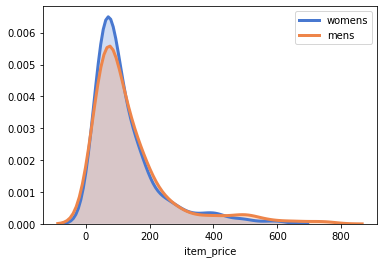

In [68]:
genders = ['womens', 'mens']
for gender in genders:
    subset = item_data[item_data['item_gender'] == gender]
    with sns.color_palette("muted"): ## changes the color palette
        sns.distplot(subset['item_price'], 
                 hist = False, 
                 kde = True, 
                 kde_kws = {'linewidth':3, 'shade': True}, 
                 label = gender)

They actually don't look too different! For both the men and womens clothing, it looks like most products are priced around 100 dollars, with a few items that are more expensive, with a greater proportion of the womens items being priced at around 100 dollars. We can also see that the data are a little right skewed - they don't follow a completely normal distribution and the tail goes out to the right to capture those higher priced items.

Another way to visualize this is with a boxplot. 

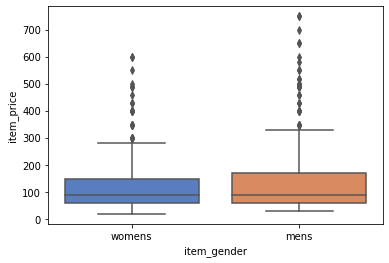

In [69]:
with sns.color_palette("muted"):
    sns.boxplot(
        x = 'item_gender', 
        y = 'item_price',
        data = item_data)

In the boxplot we can see that the median item price for womens and mens clothes is indeed around 100 dollars, with some items that are more expensive, and a greater number of more expensive items in the mens section (but not by much). Based on this boxplot too, we can again see that the data do not form a normal distribution, but are instead right skewed. 

What about the number of color options? 

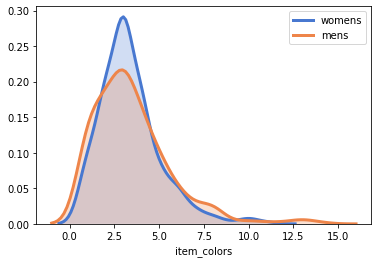

In [70]:
genders = ['womens', 'mens'] ## to plot the men and womens prices separately
for gender in genders:
    subset = item_data[item_data['item_gender'] == gender]
    with sns.color_palette("muted"): ## changes the color
        sns.distplot(subset['item_colors'], 
                     hist = False, 
                     kde = True, 
                     kde_kws = {'linewidth':3, 'shade': True}, 
                     label = gender)

The number of color options available for mens and womens clothing looks about the same too! Items on average have around 3 color options, with a higher proportion of womens clothes having this many options, but several items in both the mens and womens sections have a high number of color options. As with the item prices, this means that the data are right skewed. 

Let's look at this using a boxplot as well

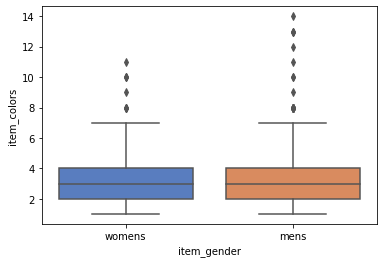

In [71]:
with sns.color_palette("muted"):
    sns.boxplot(
        x = 'item_gender', 
        y = 'item_colors',
        data = item_data)

We see here the median number of color options for womens and mens clothing is indeed around 3 colors, with a very similar number of color options between the gender categories. There are also a few more men's items that have a high number of color options. 

## A quick hypothesis test

Thanks to our visualizations above, we can see that the womens and mens clothing prices and color options are about equal. It doesn't hurt to do a quick statistical test though, just to make sure our eyes aren't deceiving us!

First let's get some numbers on the difference in the average price between mens and womens clothing (this can be thought of as a very basic measure of effect size) and get an idea of the parameters of the distribution for the mens and womens clothing prices (i.e. the mean and standard deviation)


In [72]:
## we'll want to do this for prices and colors so we can write a little function

def item_ef(category):
    """Prints mean, std, and effect size of the mens and womens item information"""
    
    w_info = item_data[category].loc[item_data['item_gender'] == 'womens']
    m_info = item_data[category].loc[item_data['item_gender'] == 'mens']
    
    ## the .3f will round the answer to 3 decimal places
    print('Womens Items: Mean=%.3f, Standard Deviation=%.3f' % (np.mean(w_info), np.std(w_info)))
    print('Mens Items: Mean=%.3f, Standard Deviation=%.3f' % (np.mean(m_info), np.std(m_info)))
    print('Difference in means=%.3f' % (np.mean(m_info) - np.mean(w_info)))

In [73]:
item_ef('item_price')

Womens Items: Mean=123.337, Standard Deviation=102.179
Mens Items: Mean=137.769, Standard Deviation=127.373
Difference in means=14.432


Our very basic measure of effect size (difference in means) tells us that mens clothes are $14.43 more expensive on average than womens clothing (interesting!)

To test for differences in average value between the two categories, we could simply perform a t-test. However, one of the assumptions of a t-test is that the data are equally distributed, and we saw in our visualizations that our data are right skewed. If you have a high enough n (number of samples), non-normality isn't a huge problem (read more about this here https://blog.minitab.com/blog/adventures-in-statistics-2/choosing-between-a-nonparametric-test-and-a-parametric-test), and we do have quite a large n, but we have other options that do not assume normality and we can use those instead. 

Rather than a t-test, we can use the Mann-Whitney U-test, a non-parametric test that still tests for differences in the average between two categories except it doesn't assume a normal distribution. It does have some other assumptions, which you can read about here (https://statistics.laerd.com/statistical-guides/mann-whitney-u-test-assumptions.php), and here https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/, the main one being that the data in each category have similar distributions (which ours do!) 

Another test we could do is a permutation test (https://towardsdatascience.com/how-to-assess-statistical-significance-in-your-data-with-permutation-tests-8bb925b2113d) but Mann-Whitney is appropriate and quite easy.

Onward with the Mann Whitney U test!

First we need to import some functions from a library that we haven't imported yet: the `mannwhitneyu` function from the `stats` component of the `scikitlearn` library

In [74]:
from scipy.stats import mannwhitneyu

In [75]:
def item_mannwhitney(category):
    """Prints statistic and P value for Mann Whitney U test for diff in mens and womens items"""
    
    w_info = item_data[category].loc[item_data['item_gender'] == 'womens']
    m_info = item_data[category].loc[item_data['item_gender'] == 'mens']
    
    ## the .3f will round the answer to 3 decimal places
    stat, p = mannwhitneyu(w_info, m_info)
    print('Statistic=%.3f, p-value=%.3f' % (stat, p))

In [76]:
item_mannwhitney('item_price')

Statistic=58216.500, p-value=0.166


And we can see based on this test that our conclusions based on our visualization were correct - there is not a significant difference between the prices for mens and womens clothing. Our null hypothesis is that mens and womens clothing are the same price on average. The statistical test provided us with a p-value of 0.17, which greater than 0.05. Thus, at an alpha level 0.05 (the common standard in statistical tests), our the difference in prices between the two categories is not significant and thus we fail to reject the null hypothesis. 

Now onto the color options data

First, lets look at effect size (diff in means)

In [77]:
item_ef('item_colors')

Womens Items: Mean=3.365, Standard Deviation=1.699
Mens Items: Mean=3.485, Standard Deviation=2.188
Difference in means=0.120


It looks like the average number of color options available for mens and womens items are about the same! 

Let's check with a Mann-Whitney test

In [78]:
item_mannwhitney('item_colors')

Statistic=60309.500, p-value=0.426


Indeed there is no statistically significant difference between the average number of color options between the mens and womens items!

### Conclusions

Phew! That was a lot! But ultimately we reached our goal:

**Goal: Scrape the item price and color options for each clothing item at Patagonia to compare the average cost and color availability for men's and women's clothing.**

And we found that on average womens and mens clothing items are **about the same**, and mens and womens clothing provide the same number of color options on average! 

Ultimately, this is good for Patagonia! It means they are not unfairly pricing their items and making womens clothing items more expensive (as many companies do! whether that's consciously or unconsciously) and they are providing equal numbers of color choices between the mens and womens clothing items as well.

Along the way we also learned how to scrape data from a website, practiced building functions, data visualizations, and statistical tests to perform a hypothesis test. Nicely done! 


### More resources:

[BeautifulSoup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

[John Laudin's Blog](http://johnlaudun.org/20180603-understanding-how-beautiful-soup-works/)

[Dr K Parker's Data Science Skills](https://towardsdatascience.com/data-science-skills-web-scraping-using-python-d1a85ef607ed)
